In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import datetime
%matplotlib inline 
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='darkgrid')

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False

In [2]:
uir_df = pd.read_csv('./uir.csv', index_col = 0)

,cust,pd_c,Rating
0,M000034966,PD0116,1.000000
1,M000034966,PD0169,1.000000
2,M000034966,PD0178,1.000000
3,M000034966,PD0204,1.000000
4,M000034966,PD0218,1.405571
...,...,...,...
1637596,M999962961,PD1857,1.000000
1637597,M999962961,PD1889,1.405571
1637598,M999962961,PD1896,1.000000
1637599,M999962961,PD1918,1.000000


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


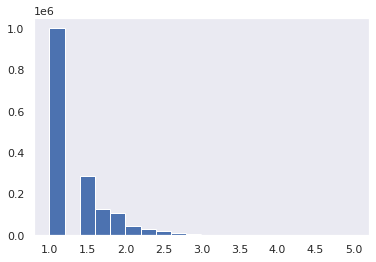

In [3]:
uir_df['Rating'] = uir_df['rct_no'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating']- uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)
uir_df = uir_df[['cust','pd_c','Rating']]
ratings = uir_df
ratings

In [7]:
class NEW_MF():
    results = []
    index = []
    for K in range(10,261,10):
        print('K = ', K)
        R_temp = ratings
        mf = NEW_MF(R_temp, K=K, alpha = 0.001, beta = 0.02, iterations = 300, verbose = True)
        test_set = mf.set_test(ratings_test)
        result = mf.test()
        index.append(K)
        results.append(result)
        
        # 최적의 iterations값 찾기
    summary = []
    for i in range(len(results)):
        RMSE = []
        for result in results[i]:
            RMSE.append(result[2])
        min = np.min(RMSE)
        j = RMSE.index(min)
        summary.append([index[i], j+1, RMSE[j]])

K =  10


NameError: name 'NEW_MF' is not defined

In [4]:
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True): # 클래스 생성시 실행되는 초기화 함수
        
        self.R = np.array(ratings) # 평점데이터를 array로 바꿔서 클래스 변수 self.R에 저장
        
        self.num_users, self.num_items = np.shape(self.R) # 사용자 수(num_users)와 아이템 수(num_items)를 받아옴
        
        self.K = K # 잠재요인의 수
        self.alpha = alpha # 학습률
        self.beta = beta # 정규화 계수
        self.iterations = iterations # SGD 반복 횟수
        self.verbose = verbose # SGD 중간 학습과정을 출력할 것인가
        
    def rmse(self): # 현재의 P, Q를 가지고 RMSE를 계산해 주는 함수
        xs,ys = self.R.nonzero() # R에서 평점이 있는(0이 아닌) 요소의 인덱스를 가져온다
        self.predictions = []
        self.errors = []
        for x,y in zip(xs, ys): # 평점이 있는 요소(사용자 x, 아이템 y) 각각에 대해서 아래의 코드를 실행
            
            # 사용자 x, 아이템 y에 대해서 평점 예측치를 get_prediction()함수를 사용해서 계산한다.
            prediction = self.get_prediction(x,y)
            
            self.predictions.append(prediction) # 예측값을 예측값 리스트에 추가
            self.errors.append(self.R[x,y] - prediction) # 실제값(R)과 예측값의 차이(errors) 계산해서 오차값 리스트에 추가
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        
        return np.sqrt(np.mean(self.errors**2)) # errors를 사용해서 RMSE를 계산
    
    def train(self): # 정해진 반복 횟수만큼 P,Q,bu,bd값을 업데이트 하는 함수
        
        # P행렬을 임의의 값으로 채움, 여기서 평균 0, 표준편차 1/K인 정규분포를 갖는 난수로 초기화
        self.P = np.random.normal(scale=1./self.K,size=(self.num_users,self.K))
        
        # Q행렬 역시 같은 방식으로 초기화
        self.Q = np.random.normal(scale=1./self.K,size=(self.num_items,self.K))
        
        # 사용자 평가경향 bu를 0으로 초기화, 사용자 평가경향이므로 array의 크기는 사용자 수(num_users)와 동일 
        self.b_u = np.zeros(self.num_users)
        
        # 아이템 평가경향 bd를 0으로 초기화, 아이템 평가경향이므로 array의 크기는 아이템 수(num_items)와 동일
        self.b_d = np.zeros(self.num_items)
        
        # 전체 평균 b를 구해서 저장
        self.b = np.mean(self.R[self.R.nonzero()])
        
        # 평점행렬R 중에서 평점이 있는(0이 아닌) 요소의 인덱스를 가져옴
        rows,columns = self.R.nonzero()
        
        # SGD를 적용할 대상, 즉 평점이 있는 요소의 인덱스와 평점을 리스트로 만들어서 samples에 저장
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows,columns)]
        
        # training_process를 초기화, 여기에는 SGD를 한번 실행할 때마다 RMSE가 얼마나 개선되는지를 기록
        training_process = []
        
        for i in range(self.iterations): # 지정한 횟수만큼 SGD를 실행
            
            # samples를 임의로 섞는다, 섞는 이유는 다른 기계학습 알고리즘과 마찬가지로 SGD를 어디서 시작하느냐에 따라,
            # 수렴의 속도가 달라질 수 있기 때문에 매 반복마다 다양한 시작점에서 출발하기 위함
            np.random.shuffle(self.samples)
            
            self.sgd() # SGD호출
            
            rmse = self.rmse() # SGD로 P,Q,bu,bd가 업데이트 되었으므로 이에 따른 새로운 RMSE를 계산
            
            training_process.append((i+1,rmse)) # 결과를 저장
            
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration : %d ; Train RMSE = %.4f " %(i+1, rmse))
        return training_process # 최종결과를 반환
    
    def get_prediction(self, i, j): # 평점 예측값을 구하는 함수
        # 사용자 i, 아이템 j에 대한 평점 예측치를 구한다
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    def sgd(self): # 실제로 SGD를 실행하는 함수
        # samples에 있는 각 (사용자 - 아이템 - 평점) 세트에 대해서 SGD를 적용한다
        for i, j, r in self.samples:
            prediction = self.get_prediction(i,j) # 사용자 i, 아이템 j에 대한 평점 예측치를 구한다.
            e = (r - prediction) # 실제 평점과 비교해서 오차를 구한다
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i]) # 사용자 평가경향(bu)를 업데이트 한다
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j]) # 아이템 평가경향(bd)를 업데이트 한다
            
            self.P[i,:] += self.alpha * (e - self.Q[j,:] - self.beta * self.P[i,:]) # P행렬을 업데이트
            self.Q[j,:] += self.alpha * (e - self.P[i,:] - self.beta * self.Q[j,:]) # Q행렬을 업데이트
            

In [5]:
R_temp = ratings.pivot(index='cust',columns='pd_c',values='Rating').fillna(0)
# ratings데이터를 full matrix로 변환한다. MF클래스 내부적으로 full matrix(self.R)를 계산에 사용하기 때문에 미리 변환

In [11]:
mf = MF(R_temp, K=10, alpha=0.001, beta=0.02, iterations=10, verbose=True)
# MF클래스를 생성, 잠재요인 K=30, alpha=0.001, beta=0.02, 반복횟수 iterations=100, verbose=True로 생성

In [12]:
train_process = mf.train()

Iteration : 10 ; Train RMSE = 4.5451 


/var/folders/1r/w554lp_s677_dbwqw3vmnhmh0000gn/T/ipykernel_28956/2969017768.py:88: RuntimeWarning: invalid value encountered in subtract
  self.Q[j,:] += self.alpha * (e - self.P[i,:] - self.beta * self.Q[j,:]) # Q행렬을 업데이트
/var/folders/1r/w554lp_s677_dbwqw3vmnhmh0000gn/T/ipykernel_28956/2969017768.py:84: RuntimeWarning: invalid value encountered in double_scalars
  self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i]) # 사용자 평가경향(bu)를 업데이트 한다
/var/folders/1r/w554lp_s677_dbwqw3vmnhmh0000gn/T/ipykernel_28956/2969017768.py:87: RuntimeWarning: invalid value encountered in add
  self.P[i,:] += self.alpha * (e - self.Q[j,:] - self.beta * self.P[i,:]) # P행렬을 업데이트
/var/folders/1r/w554lp_s677_dbwqw3vmnhmh0000gn/T/ipykernel_28956/2969017768.py:75: RuntimeWarning: invalid value encountered in double_scalars
  prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)


Iteration : 20 ; Train RMSE = nan 
Iteration : 30 ; Train RMSE = nan 
Iteration : 40 ; Train RMSE = nan 
Iteration : 50 ; Train RMSE = nan 
Iteration : 60 ; Train RMSE = nan 
Iteration : 70 ; Train RMSE = nan 
Iteration : 80 ; Train RMSE = nan 
Iteration : 90 ; Train RMSE = nan 
Iteration : 100 ; Train RMSE = nan 


코드에 문제가 있거나, 데이터에 문제가 있는것 같다...ㅠㅠ, 정확도가 너무 처참하다

### train/test 분리 MF 알고리즘

In [13]:
from sklearn.utils import shuffle # shuffle 라이브러리 불러오기

TRAIN_SIZE = 0.75 # train set의 비율을 75%, test set의 비율을 25%로 지정한다

# ratings를 무작위로 섞는다, 이 rating은 (사용자 - 영화 - 평점)이 하나의 세트로 되어 있기 때문에 섞어도 문제가 없음
ratings = shuffle(ratings, random_state=1) 
cutoff = int(TRAIN_SIZE * len(ratings)) # 전체 데이터중 TRAIN_SIZE의 비율에 해당하는 데이터가 몇 개인지 계산한다.
ratings_train = ratings.iloc[:cutoff] # 무작위로 섞인 데이터 중 TRAIN_SIZE에 해당하는 앞의 데이터를 ratings_train에 저장한다
ratings_test = ratings.iloc[cutoff:] # 나머지 뒷부분의 데이터를 ratings_test에 저장
ratings = ratings.pivot(index = 'cust', columns = 'pd_c', values='Rating').fillna(0)

KeyError: 'cust'

In [ ]:
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R) # 사용자 수(num_users)와 아이템 수(num_items)를 받아옴
        self.K = K # 잠재요인의 수
        self.alpha = alpha # 학습률
        self.beta = beta # 정규화 계수
        self.iterations = iterations # SGD 반복 횟수
        self.verbose = verbose # SGD 중간 학습과정을 출력할 것인가
        
        item_id_index = []
        index_item_id = []
        
        for i, one_id in enumerate(ratings): # ratings의 각 아이템에 대해서 아래 작업을 수행
            
            # 아이디를 인덱스로 매핑해 주는 맵 item_id_index에 현재 아이템의 아이디와 인덱스를 저장
            item_id_index.append([one_id, i]) 
             # 반대로 인덱스를 아이디로 매핑해 주는 맵 index_item_id에 현재 아이템의 인덱스와 아이디를 저장
            index_item_id.append([i, one_id])
        # 만들어진 맵을 dictionary 형태로 변환    
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i,one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        
    def set_test(self, ratings_test): # 분리된 test set을 넘겨받아서 클래스 내부의 test set을 만드는 함수
        test_set = [] # test set에 해당되는 (사용자-아이템-평점)을 저장하는 test_set을 초기화
        for i in range(len(ratings_test)): # 테스트 데이터에서 각(사용자 - 아이템 - 평점)에 대해서 아래 작업을 반복
            x = self.user_id_index[ratings_test.iloc[i,0]] # 현재 사용자의 인덱스를 user_id_index에서 받아온다
            y = self.item_id_index[ratings_test.iloc[i,1]] # 현재 아이템의 인덱스를 item_id_index에서 받아온다
            z = ratings_test.iloc[i,2] # 현재 사용자-아이템의 평점을 받아온다
            test_set.append([x,y,z]) # 현재 (사용자-아이템-평점)을 test_set에 추가한다
            # 해당(사용자-아이템-평점)을 R에서 0으로 지운다, 지우는 이유는 R을 사용해서 MF모델을 학습을 하기 때문에 test set은
            # R에서 제거해야 되기 때문
            self.R[x,y] = 0  
        self.test_set = test_set # test_set을 클래스에 저장
        return test_set # test_set을 결과로 반환
    
    def rmse(self): # 현재의 P, Q를 가지고 RMSE를 계산해 주는 함수
        xs,ys = self.R.nonzero() # R에서 평점이 있는(0이 아닌) 요소의 인덱스를 가져온다
        self.predictions = []
        self.errors = []
        for x,y in zip(xs, ys): # 평점이 있는 요소(사용자 x, 아이템 y) 각각에 대해서 아래의 코드를 실행
            
            # 사용자 x, 아이템 y에 대해서 평점 예측치를 get_prediction()함수를 사용해서 계산한다.
            prediction = self.get_prediction(x,y)
            
            self.predictions.append(prediction) # 예측값을 예측값 리스트에 추가
            self.errors.append(self.R[x,y] - prediction) # 실제값(R)과 예측값의 차이(errors) 계산해서 오차값 리스트에 추가
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        
        return np.sqrt(np.mean(self.errors**2)) # errors를 사용해서 RMSE를 계산
    
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error / len(self.test_set))
    
    def test(self):
        self.P = np.random.normal(scale = 1./self.K, size = (self.num_users, self.K))
        self.Q = np.random.normal(scale = 1./self.K, size = (self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])
        
        rows, columns = self.R.nonzero()
        self.samples = [(i,j,self.R[i,j]) for i,j in zip(rows, columns)]
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" %(i+1, rmse1, rmse2))
        return training_process
    
    def get_prediction(self, i, j): # 평점 예측값을 구하는 함수
        # 사용자 i, 아이템 j에 대한 평점 예측치를 구한다
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
    
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)
    
    def sgd(self): # 실제로 SGD를 실행하는 함수
        # samples에 있는 각 (사용자 - 아이템 - 평점) 세트에 대해서 SGD를 적용한다
        for i, j, r in self.samples:
            prediction = self.get_prediction(i,j) # 사용자 i, 아이템 j에 대한 평점 예측치를 구한다.
            e = (r - prediction) # 실제 평점과 비교해서 오차를 구한다
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i]) # 사용자 평가경향(bu)를 업데이트 한다
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j]) # 아이템 평가경향(bd)를 업데이트 한다
            
            self.P[i,:] += self.alpha * (e - self.Q[j,:] - self.beta * self.P[i,:]) # P행렬을 업데이트
            self.Q[j,:] += self.alpha * (e - self.P[i,:] - self.beta * self.Q[j,:]) # Q행렬을 업데이트

In [ ]:
R_temp = ratings
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta = 0.02, iterations = 10, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()